In [1]:
import pennylane as qml
import pennylane.numpy as np
from model import Model

In [12]:
name = 'ward'


# def func(rho_s, alpha_x, alpha_y, u, v, theta_i, theta_o):
# 	phi_h = np.arctan(alpha_y / alpha_x * np.tan(2 * np.pi * v))

# 	theta_h = np.arctan(
# 		np.sqrt((-np.log(u)) / ((np.cos(phi_h) / alpha_x) ** 2 + (np.sin(phi_h) / alpha_y) ** 2))
# 	)

# 	exp_1 = -(np.tan(theta_h) ** 2)

# 	exp_2 = (np.cos(phi_h) ** 2 / alpha_x**2 + np.sin(phi_h) ** 2 / alpha_y**2)

# 	exp = np.exp(
# 		exp_1
# 		* exp_2
# 	)
# 	coef = rho_s / (4 * np.pi * alpha_x * alpha_y * np.sqrt(np.cos(theta_i) * np.cos(theta_o)))

# 	if coef * exp > 1:
# 		print(exp_1, exp_2, exp, coef, rho_s, alpha_x, alpha_y, theta_i, theta_o, coef * exp)

# 	return coef * exp


def func(rho_s, alpha, u, v, theta_i, phi_i):
	phi_h = 2 * np.pi * v

	theta_h = np.arctan(alpha * np.sqrt(-np.log(u)))

	half = np.array([np.cos(phi_h)*np.sin(theta_h), np.sin(phi_h) * np.sin(theta_h), np.cos(theta_h)])

	inp = np.array([np.cos(phi_i)*np.sin(theta_i), np.sin(phi_i) * np.sin(theta_i), np.cos(theta_i)])

	out = 2*np.dot(inp,half)*half - inp

	out = out / np.linalg.norm(out)

	exp = np.exp(-(np.tan(theta_h) ** 2) / alpha**2)
	coef = rho_s / (4 * np.pi * alpha * alpha * np.sqrt(np.cos(theta_i) * out[2]))

	if out[2] < 0:
		print('negative')

	# if coef * exp > 1:
	# 	print(exp, coef, rho_s, alpha, theta_i, phi_i,out, coef * exp)

	return coef * exp


consts = {'': 0}
scalars = {
	'rho_s': {'range': (0.5, 1), 'type': np.float32},
	# 'alpha_x': {'range': (0.25, 0.75), 'type': np.float32},
	# 'alpha_y': {'range': (0.25, 0.75), 'type': np.float32},
	'alpha': {'range': (0.25, 0.75), 'type': np.float32},
	'u': {'range': (0, 1), 'type': np.float32},
	'v': {'range': (0, 1), 'type': np.float32},
}
angles = {
	'theta_i': {'range': (0, np.pi / 2)},
	'theta_o': {'range': (0, np.pi / 2)},
}

In [13]:
model = Model()
model.set_name(name)
model.set_function(func)
# model.set_consts(consts)
model.set_scalars(scalars)
model.set_angles(angles)

model.set_sample_size(1000)

try:
	model.read_samples('samples/' + model.name + '.bin')
except FileNotFoundError:
	model.generate_samples()
	model.read_samples('samples/' + model.name + '.bin')

model.separate()

/home/diogo/thesis/.venv/lib/python3.12/site-packages/pennylane/numpy/tensor.py:152: RuntimeWarning: invalid value encountered in sqrt
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
negative
n

/home/diogo/thesis/.venv/lib/python3.12/site-packages/pennylane/numpy/tensor.py:152: RuntimeWarning: invalid value encountered in arcsin
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


(<Figure size 11300x700 with 1 Axes>, <Axes: >)

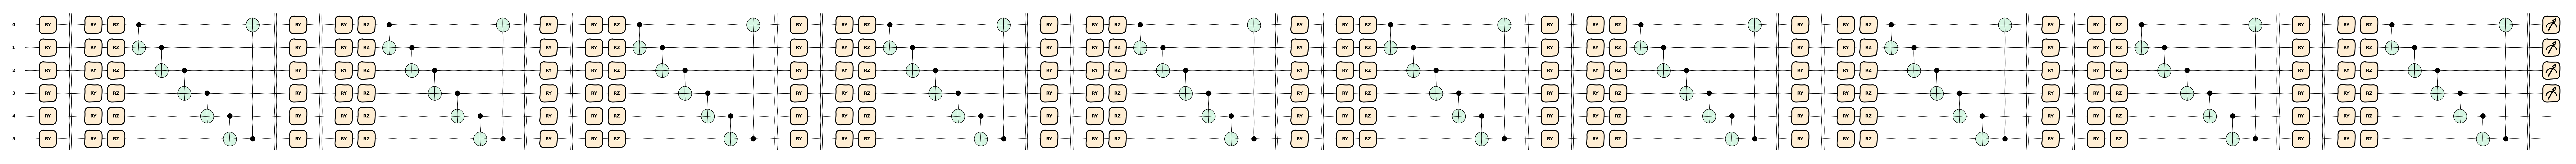

In [ ]:
n_qubits = len(model.scalars) + len(model.angles)
layers = 10

model.generate_device(n_qubits)

def embedding(data, n_qubits):
	for i in range(n_qubits):
		if i < len(model.scalars):
			value = data[i]
			name = model.header[i + len(model.consts)]
			(min, max) = model.scalars.get(name).get('range')
			if min == max:
				value = 0.5
			else:
				value = (value - min) / (max - min)
			qml.RY(np.arcsin(value), wires=i)
		else:
			qml.RY(data[i], wires=i)

	qml.Barrier()

def rot_ent(params, n_qubits):
	if len(params) < n_qubits * 2:
		raise ValueError('Not enough params')

	for i in range(n_qubits):
		# qml.RX(params[3 * i], wires=i)
		qml.RY(params[2 * i], wires=i)
		qml.RZ(params[2 * i + 1], wires=i)

	for i in range(n_qubits):
		qml.CNOT(wires=[i, (i + 1) % n_qubits])

	qml.Barrier()

def _circuit(data, params):
	for i in range(layers):
		embedding(data, n_qubits)

		rot_ent(params[i * n_qubits * 2 : (i + 1) * n_qubits * 2], n_qubits)

	return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

def _model(circ, input, params):
	return circ(input, params)

model.set_model(_model)
model.set_circuit(_circuit)
model.generate_params((n_qubits * 2 * layers,))

qml.draw_mpl(model.circuit, style='sketch')(model.train_in, model.params)

In [5]:
model.set_steps(10)
model.optimization(callback= True)

Step 0 -> Loss: 3.1194348823595797
Step 1 -> Loss: 3.023269078913538
Step 2 -> Loss: 2.9676743751317605
Step 3 -> Loss: 2.9383635527848733
Step 4 -> Loss: 2.9181013401369746
Step 5 -> Loss: 2.902357330090717
Step 6 -> Loss: 2.8929797327865154
Step 7 -> Loss: 2.8904601910214796
Step 8 -> Loss: 2.8854152227155203
Step 9 -> Loss: 2.8764689172990865


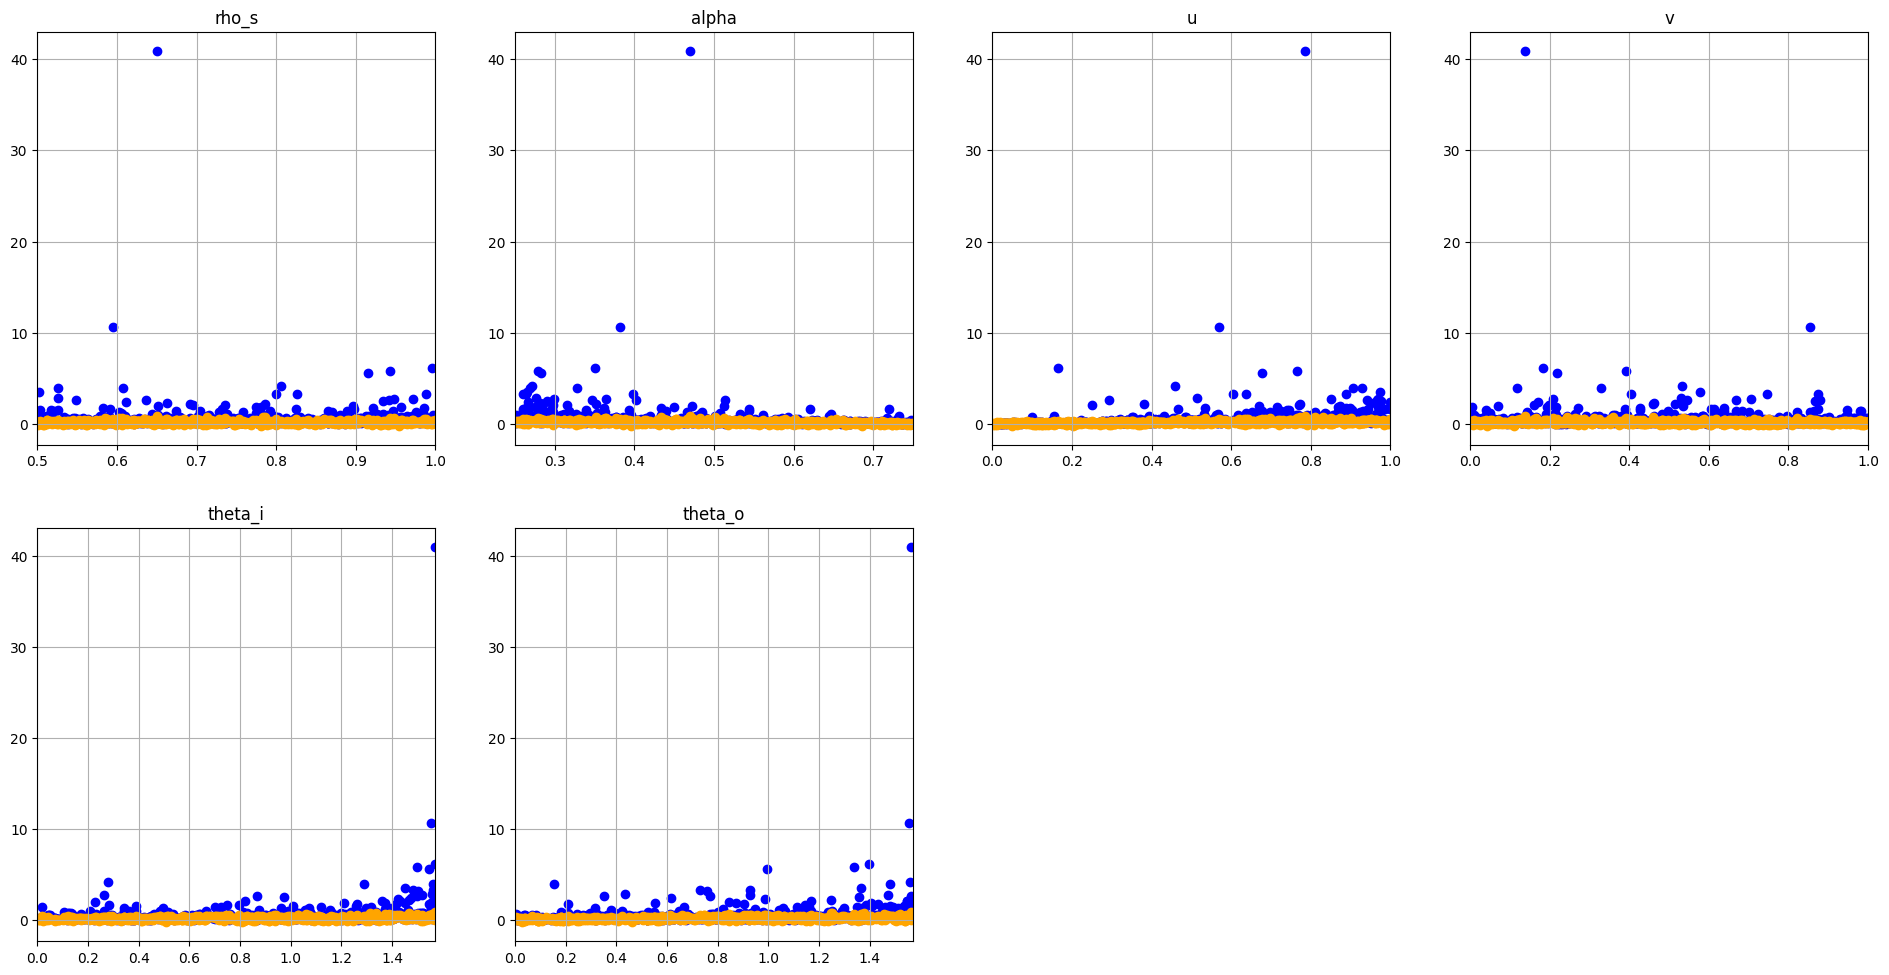

In [6]:
model.draw()

In [7]:
print('Test score:', model.test())

Test score: 15.902471873958147


In [8]:
model.serialize('models/' + model.name + '.json')